The provided code performs the following high-level concepts:

1. **Data Loading**: The code loads data from the results of measurements for Clingo, DLV, and Vlog. It reads and processes the output files associated with each result type.

2. **Data Trimming**: The code trims the loaded data by filtering out certain instances based on specific conditions. It removes instances where the time limit was reached or where data is missing. Additionally, it eliminates instances with high standard deviation in the results.

3. **Comparison with Disjunctions**: The code compares the average execution times of Clingo and DLV for instances that include disjunctions in their rules. It visualizes the comparison using scatter plots and trend lines.

4. **Comparison without Disjunctions**: The code performs a similar comparison of average execution times but for instances without disjunctions in their rules. It visualizes this comparison as well.

5. **Conclusion**: Based on the comparisons, the code presents conclusions regarding the relative performance of Clingo, DLV, and Vlog in terms of execution times. It determines if Clingo is faster than DLV and if Vlog is noticeably slower than Clingo and DLV.

Overall, the code focuses on analyzing and comparing the execution times of different rule-based systems (Clingo, DLV, and Vlog) under specific conditions, such as the presence or absence of disjunctions in the rules. It provides insights into the relative performance of these systems based on the available data.

In [261]:
import os, glob, pickle, re, numpy as np, pandas as pd, matplotlib.pyplot as plt

RULE_FOLDER = '../_rules'
RESULTS_FOLDER = '../_results/results'

In [262]:
def count_file_lines(file):
    with open(file, 'r') as fp:
        return sum(1 for line in fp)

In [263]:
def load_rules():
    return {idx.split('/')[-1]: count_file_lines(idx) for idx in glob.glob(RULE_FOLDER + '/*')}

In [264]:
def count_file_lines(file):
    with open(file, 'r') as fp:
        return sum(1 for line in fp)

In [265]:
def load_rules():
    return [
            {
                'id': idx.split('/')[-1],
                'rules': count_file_lines(idx),
            } for idx in glob.glob(RULE_FOLDER + '/*')
    ]

## Load the rules and calculate their 'size'

In [266]:
rules_checkpoint_file = './checkpoints/rules'
if os.path.exists(rules_checkpoint_file):
    file = open(rules_checkpoint_file, 'rb')
    rules = pickle.load(file)
    file.close()
else:
    file = open(rules_checkpoint_file, 'wb')
    rules = load_rules()
    pickle.dump(rules, file)
    file.close()

## Load the results and calculate their 'size'

In [283]:
results = ['out_full_clingo1', 'out_full_clingo2', 'out_full_clingo3', 'out_full_dlv1', 'out_vlog1', 'out_vlog2', 'out_vlog3']
for type in results:
    for r in rules:
        finds = None
        result_name = '_'.join(['time', type])
        filename = RESULTS_FOLDER + '/' + type + '/' + r['id']
        if os.path.exists(filename):
            with open(filename, 'rb') as file:
                output = file.readlines()
                if type.find('clingo') != -1:
                    time_limit_reached = len(list(filter(lambda x: re.match('^TIME LIMIT', x.decode()), output))) > 0

                if time_limit_reached:
                    finds = None
                else:
                    if type.find('clingo') != -1:
                        finds = list( filter(lambda x: re.match('^Time', x.decode()), output) )
                        times = list(map(lambda x: re.search('^Time\s+:\s*(.*)s\s\(', x.decode()).group(1), finds))
                    else:
                        finds = list( filter(lambda x: re.match('^\.\.\. finished in', x.decode()), output) )
                        times = list(map(lambda x: re.search('^\.\.\. finished in (\d+)ms\s\(', x.decode()).group(1), finds))
                    finds = times[0] if len(times) > 0 else None
        r[ result_name ] = finds


## Load the data in a pandas dataframe

In [284]:
dataset = pd.json_normalize(rules)

In [286]:
dataset

,id,rules,time_out_full_clingo1,time_out_full_clingo2,time_out_full_clingo3,time_out_full_dlv1,time_out_vlog1,time_out_vlog2,time_out_vlog3
0,3b4e270b-0efb-471f-b7b8-a8a4578e79ce_ter_wrenc...,353,0.016,0.018,0.015,39,None,None,None
1,674f39d8-fe7f-4bb6-b866-bdb6abc6ae90_functions...,1569,0.000,0.000,0.000,8,1,0,1
2,0b3204d4-768b-4e1f-b8a6-33d629d5ae91_xaosimple...,6480,0.146,0.146,0.151,269,193,188,203
3,6e41b96f-71e7-42e6-a643-0a84d3b6f6fc_opl.owl.o...,1997,None,None,None,None,None,None,None
4,4d2e22bf-487b-47a4-8418-c16f8fe5c826_owlfacts....,59,0.004,0.004,0.005,18,None,None,None
...,...,...,...,...,...,...,...,...,...
20356,3a8f019a-326c-4596-ba73-a8508e78b7b0_ChangeOnt...,189,0.009,0.010,0.010,19,6,5,6
20357,3fb09e67-8d83-438e-a8c6-dc276dd958b3_37721.rdf...,7,0.000,0.000,0.000,9,2,2,2
20358,3bb1edc8-868c-4442-9d18-1ed0e1584757_2v2_Turtl...,183,None,None,None,None,30010,30005,30004
20359,0e3cd458-420f-4dfb-88f7-06dfcfa12805_lusunipro...,5682,0.104,0.100,0.102,417,134,140,134


In [287]:

dataset['clingo_avg'] = (dataset.filter(like='clingo').apply(pd.to_numeric, errors='coerce') * 1000 ).mean(axis=1)
dataset['vlog_avg'] = (dataset.filter(like='vlog').apply(pd.to_numeric, errors='coerce') * 1000 ).mean(axis=1)
dataset['dlv_avg'] = dataset.filter(like='dlv').apply(pd.to_numeric, errors='coerce').mean(axis=1)

dataset['clingo_std'] = dataset.filter(like='clingo').apply(pd.to_numeric, errors='coerce').std(axis=1)
dataset['vlog_std'] = dataset.filter(like='vlog').apply(pd.to_numeric, errors='coerce').std(axis=1)
dataset['dlv_std'] = dataset.filter(like='dlv').apply(pd.to_numeric, errors='coerce').std(axis=1)


In [288]:
dataset

,id,rules,time_out_full_clingo1,time_out_full_clingo2,time_out_full_clingo3,time_out_full_dlv1,time_out_vlog1,time_out_vlog2,time_out_vlog3,clingo_avg,vlog_avg,dlv_avg,clingo_std,vlog_std,dlv_std
0,3b4e270b-0efb-471f-b7b8-a8a4578e79ce_ter_wrenc...,353,0.016,0.018,0.015,39,None,None,None,16.333333,NaN,39.0,8.1585,NaN,0.0
1,674f39d8-fe7f-4bb6-b866-bdb6abc6ae90_functions...,1569,0.000,0.000,0.000,8,1,0,1,0.000000,6.666667e+02,8.0,0.0000,3.330003e+02,0.0
2,0b3204d4-768b-4e1f-b8a6-33d629d5ae91_xaosimple...,6480,0.146,0.146,0.151,269,193,188,203,147.666667,1.946667e+05,269.0,73.7595,9.723600e+04,0.0
3,6e41b96f-71e7-42e6-a643-0a84d3b6f6fc_opl.owl.o...,1997,None,None,None,None,None,None,None,NaN,NaN,NaN,NaN,NaN,NaN
4,4d2e22bf-487b-47a4-8418-c16f8fe5c826_owlfacts....,59,0.004,0.004,0.005,18,None,None,None,4.333333,NaN,18.0,2.1645,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20356,3a8f019a-326c-4596-ba73-a8508e78b7b0_ChangeOnt...,189,0.009,0.010,0.010,19,6,5,6,9.666667,5.666667e+03,19.0,4.8285,2.830500e+03,0.0
20357,3fb09e67-8d83-438e-a8c6-dc276dd958b3_37721.rdf...,7,0.000,0.000,0.000,9,2,2,2,0.000000,2.000000e+03,9.0,0.0000,9.990000e+02,0.0
20358,3bb1edc8-868c-4442-9d18-1ed0e1584757_2v2_Turtl...,183,None,None,None,None,30010,30005,30004,NaN,3.000633e+07,NaN,NaN,1.498816e+07,NaN
20359,0e3cd458-420f-4dfb-88f7-06dfcfa12805_lusunipro...,5682,0.104,0.100,0.102,417,134,140,134,102.000000,1.360000e+05,417.0,50.9490,6.793200e+04,0.0


## Subset the data

Remove the instances where the time limit was reached, data is missing, or the stdev of the results is too high

In [289]:
with_disjunction_important_columns = ['id', 'rules', 'clingo_avg', 'dlv_avg']
wo_disjunction_important_columns = ['id', 'rules', 'clingo_avg', 'dlv_avg', 'vlog_avg']

sdwod = sub_dataset_wo_disjunction = dataset.dropna(subset=wo_disjunction_important_columns)
sdwd = sub_dataset_with_disjunction = dataset.dropna(subset=with_disjunction_important_columns)

In [290]:
sdwod = sub_dataset_wo_disjunction = sdwod.where((dataset['clingo_std'] < 0.05) | (dataset['dlv_std'] < 0.05) | (dataset['vlog_std'] < 0.05))
sdwd = sub_dataset_with_disjunction = sdwd.where((dataset['clingo_std'] < 0.05) | (dataset['dlv_std'] < 0.05))

sdwod = sub_dataset_wo_disjunction = sdwod.where((dataset['clingo_avg'] > 0) & (dataset['dlv_avg'] > 0) & (dataset['vlog_avg'] > 0))
sdwd = sub_dataset_with_disjunction = sdwd.where((dataset['clingo_avg'] > 0) & (dataset['dlv_avg'] > 0))

sdwod = sub_dataset_wo_disjunction = dataset.dropna(subset=wo_disjunction_important_columns)
sdwd = sub_dataset_with_disjunction = dataset.dropna(subset=with_disjunction_important_columns)



In [291]:
sdwd

,id,rules,time_out_full_clingo1,time_out_full_clingo2,time_out_full_clingo3,time_out_full_dlv1,time_out_vlog1,time_out_vlog2,time_out_vlog3,clingo_avg,vlog_avg,dlv_avg,clingo_std,vlog_std,dlv_std
0,3b4e270b-0efb-471f-b7b8-a8a4578e79ce_ter_wrenc...,353,0.016,0.018,0.015,39,None,None,None,16.333333,NaN,39.0,8.1585,NaN,0.0
1,674f39d8-fe7f-4bb6-b866-bdb6abc6ae90_functions...,1569,0.000,0.000,0.000,8,1,0,1,0.000000,666.666667,8.0,0.0000,333.000334,0.0
2,0b3204d4-768b-4e1f-b8a6-33d629d5ae91_xaosimple...,6480,0.146,0.146,0.151,269,193,188,203,147.666667,194666.666667,269.0,73.7595,97236.000200,0.0
4,4d2e22bf-487b-47a4-8418-c16f8fe5c826_owlfacts....,59,0.004,0.004,0.005,18,None,None,None,4.333333,NaN,18.0,2.1645,NaN,0.0
5,db8458b9-6ce0-4bf5-81ea-d9f41ddffcd1_swrl.rdf....,26,0.002,0.002,0.001,10,2,2,2,1.666667,2000.000000,10.0,0.8325,999.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20355,8af409af-7d64-4e38-8335-e8c93c4c0c1b_ka.owl.ow...,462,0.022,0.026,0.025,29,12,12,12,24.333333,12000.000000,29.0,12.1545,5994.000000,0.0
20356,3a8f019a-326c-4596-ba73-a8508e78b7b0_ChangeOnt...,189,0.009,0.010,0.010,19,6,5,6,9.666667,5666.666667,19.0,4.8285,2830.500039,0.0
20357,3fb09e67-8d83-438e-a8c6-dc276dd958b3_37721.rdf...,7,0.000,0.000,0.000,9,2,2,2,0.000000,2000.000000,9.0,0.0000,999.000000,0.0
20359,0e3cd458-420f-4dfb-88f7-06dfcfa12805_lusunipro...,5682,0.104,0.100,0.102,417,134,140,134,102.000000,136000.000000,417.0,50.9490,67932.000059,0.0


## Compare Clingo vs DLV (with disjunctions)

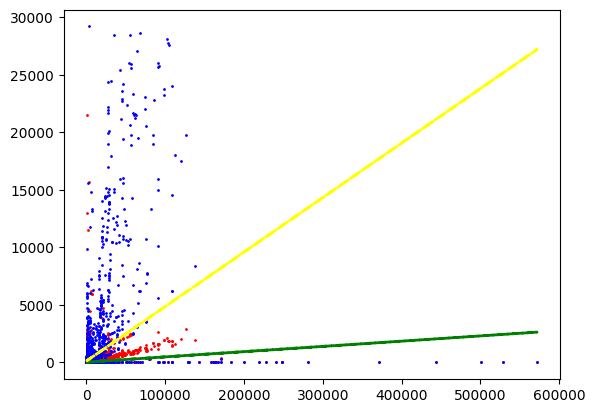

In [292]:
x1 = sub_dataset_with_disjunction['rules']
y1 = sub_dataset_with_disjunction['clingo_avg']
m, n = np.polyfit(x1, y1, 1)
plt.scatter(x1, y1, color='red', s=1)
plt.plot(x1, m*x1 + n, color='green', linestyle='--', linewidth=2)

x2 = sub_dataset_with_disjunction['rules']
y2 = sub_dataset_with_disjunction['dlv_avg']
m, n = np.polyfit(x2, y2, 1)
plt.scatter(x2, y2, color='blue', s=1)
plt.plot(x2, m*x2 + n, color='yellow', linestyle='--', linewidth=2)


## Compare Clingo vs DLV vs Vlog (without disjunctions)

In [ ]:
x1 = sub_dataset_wo_disjunction['rules']
y1 = sub_dataset_wo_disjunction['clingo_avg']
m, n = np.polyfit(x1, y1, 1)
plt.scatter(x1, y1, color='red', s=1)
plt.plot(x1, m * x1 + n, color='green', linestyle='--', linewidth=2)

x2 = sub_dataset_wo_disjunction['rules']
y2 = sub_dataset_wo_disjunction['dlv_avg']
m, n = np.polyfit(x2, y2, 1)
plt.scatter(x2, y2, color='blue', s=1)
plt.plot(x2, m * x2 + n, color='yellow', linestyle='--', linewidth=2)

x3 = sub_dataset_wo_disjunction['rules']
y3 = sub_dataset_wo_disjunction['vlog_avg']
m, n = np.polyfit(x3, y3, 1)
plt.scatter(x3, y3, color='green', s=1)
plt.plot(x3, m * x3 + n, color='pink', linestyle='--', linewidth=2)


## Compare Clingo vs DLV (without disjunctions)

Removed Vlog as it was decidedly slower

In [ ]:
x1 = sub_dataset_wo_disjunction['rules']
y1 = sub_dataset_wo_disjunction['clingo_avg']
m, n = np.polyfit(x1, y1, 1)
plt.scatter(x1, y1, color='red', s=1)
plt.plot(x1, m * x1 + n, color='green', linestyle='--', linewidth=2)

x2 = sub_dataset_wo_disjunction['rules']
y2 = sub_dataset_wo_disjunction['dlv_avg']
m, n = np.polyfit(x2, y2, 1)
plt.scatter(x2, y2, color='blue', s=1)
plt.plot(x2, m * x2 + n, color='yellow', linestyle='--', linewidth=2)



# Conclusion

## Without disjunction
### Is Clingo faster than both DLV and Vlog?

In [298]:
sdwod = sub_dataset_wo_disjunction
((sdwod['clingo_avg'] < sdwod['dlv_avg']) & (sdwod['clingo_avg'] < sdwod['vlog_avg'])).value_counts()

True     12773
False     1256
Name: count, dtype: int64

## With disjunction
### Distribution of the fastest execution time

clingo_avg    19443
vlog_avg       1227
dlv_avg          42
dtype: int64


<Axes: >

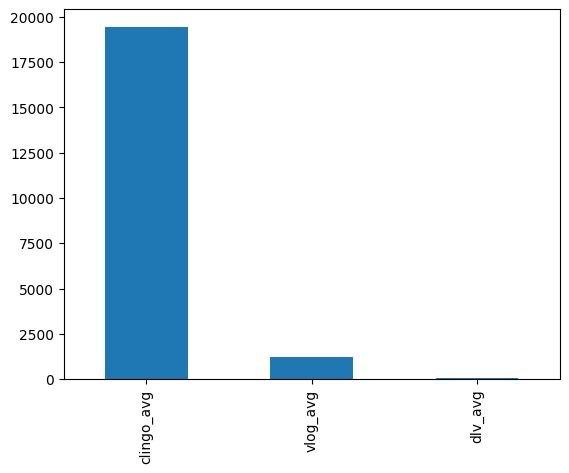

In [317]:
sdwd = sub_dataset_with_disjunction
fastest_time = sdwd.filter(like='_avg').eq(sdwd.filter(like='_avg').min(axis=1), axis=0).sum()
print(fastest_time)
fastest_time.plot(kind='bar')


clingo_avg    14000
vlog_avg       1227
dlv_avg          29
dtype: int64


<Axes: >

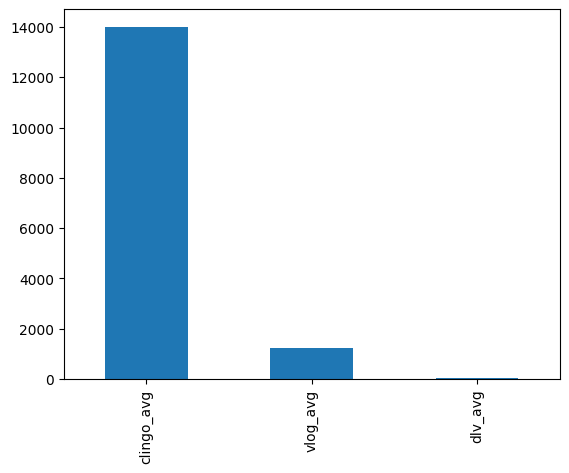

In [318]:
sdwod = sub_dataset_wo_disjunction
fastest_time = sdwod.filter(like='_avg').eq(sdwod.filter(like='_avg').min(axis=1), axis=0).sum()
print(fastest_time)
fastest_time.plot(kind='bar')